In [1]:
import os
import hashlib
import time
import torch
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.font_manager as fm
from Bio import SeqIO
from tqdm import tqdm
from functools import partial
from datetime import datetime
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import (
    EsmTokenizer,
    EsmForMaskedLM,
    AutoTokenizer,
    AutoModel
)
from peft import PeftModel
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

In [3]:
def generate_anchor_embeddings_batch(sequences, tokenizer, model, device, batch_size=32):
    model.to(device)
    embeddings = []
    for i in range(0, len(sequences), batch_size):
        batch_sequences = sequences[i:i + batch_size]
        inputs = tokenizer(batch_sequences, return_tensors="pt", padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            output = model.esm(**inputs).last_hidden_state
            mean_output = output[:, 1:output.size(1)].mean(dim=1)
        embeddings.append(mean_output.cpu())
        torch.cuda.empty_cache()
    return torch.cat(embeddings, dim=0)

def generate_mol_embeddings_batch(smiles_list, tokenizer, model, device, batch_size=32):
    model.to(device)
    embeddings = []
    for i in range(0, len(smiles_list), batch_size):
        batch_smiles = smiles_list[i:i + batch_size]
        inputs = tokenizer(batch_smiles, padding=True, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            mol_embedding = outputs.pooler_output
        embeddings.append(mol_embedding.cpu())
        torch.cuda.empty_cache()
    return torch.cat(embeddings, dim=0)

In [4]:
class Coembedding(nn.Module):
    def __init__(
        self,
        molecule_shape=768,
        protein_shape=1280,
        latent_dimension=1024,
        latent_activation=nn.ReLU,
        latent_distance="Cosine",
        classify=True,
        temperature=0.1
    ):
        super(Coembedding, self).__init__()
        self.molecule_projector = nn.Sequential(
            nn.Linear(molecule_shape, latent_dimension),
            latent_activation(),
            nn.Linear(latent_dimension, latent_dimension)
        )
        self.protein_projector = nn.Sequential(
            nn.Linear(protein_shape, latent_dimension),
            latent_activation(),
            nn.Linear(latent_dimension, latent_dimension)
        )
        self.temperature = nn.Parameter(torch.tensor(temperature))
        self.do_classify = classify

        if classify:
            self.distance_metric = latent_distance
            self.activator = nn.CosineSimilarity(dim=-1)

    def forward(self, molecule, protein):
        if self.do_classify:
            return self.classify(molecule, protein)

    def classify(self, molecule, protein):
        molecule_projection = self.molecule_projector(molecule)
        protein_projection = self.protein_projector(protein)

        molecule_projection = molecule_projection.unsqueeze(0) 
        protein_projection = protein_projection.unsqueeze(1)
        
        distance = self.activator(molecule_projection, protein_projection)
        scaled_distance = distance / self.temperature
        return scaled_distance

In [ ]:
model_name = '../models/esm2/esm2_t33_650M_UR50D'
prot_tokenizer = EsmTokenizer.from_pretrained(model_name)
base_model = EsmForMaskedLM.from_pretrained(model_name)
prot_model = PeftModel.from_pretrained(base_model, '../models/plm')

mol_model_path = "../models/ibm/MoLFormer-XL-both-10pct"
mol_tokenizer = AutoTokenizer.from_pretrained(mol_model_path, trust_remote_code=True)
mol_model = AutoModel.from_pretrained(mol_model_path, deterministic_eval=True, trust_remote_code=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = pd.read_excel("../data/T2_data_norm.csv")
data = data.drop_duplicates(subset = ['canonicalsmiles'])

prot_seq = data.sequence.tolist()
mol_smiles = data.canonicalsmiles.tolist()

prot_emb = generate_anchor_embeddings_batch(
        prot_seq, prot_tokenizer, prot_model, device
    )

mol_emb = generate_mol_embeddings_batch(
        mol_smiles, mol_tokenizer, mol_model, device
    )

model = Coembedding().to(device)
model.load_state_dict(torch.load('../models/best_model.pth')['model_state_dict'])
model.eval()

Coembedding(
  (molecule_projector): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (protein_projector): Sequential(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (activator): CosineSimilarity()
)

/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


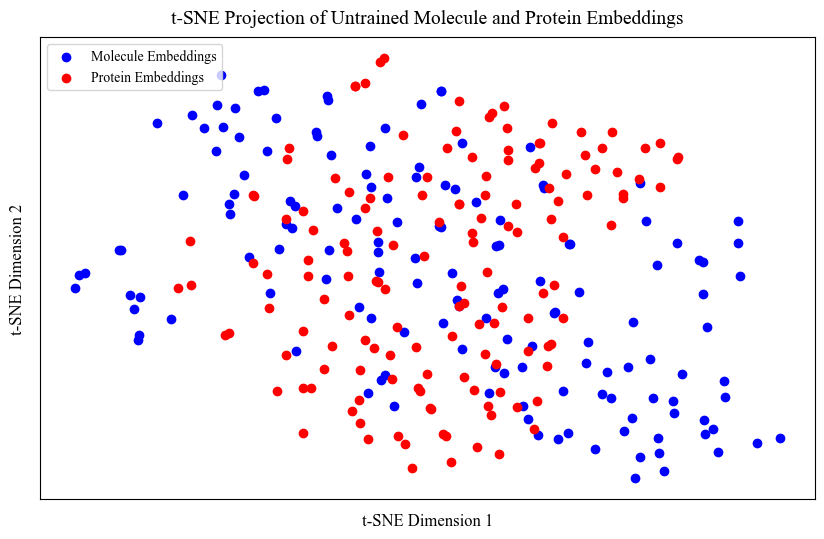

In [ ]:
# Load custom Times New Roman font
font_path = '../times.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Times New Roman'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

untrained_prot_emb = prot_emb
untrained_mol_emb = mol_emb

# Transfer embeddings to CPU for t-SNE processing
untrained_prot_emb_cpu = untrained_prot_emb.cpu()
untrained_mol_emb_cpu = untrained_mol_emb.cpu()

# Apply t-SNE for dimensionality reduction
tsne_model = TSNE(n_components=2, random_state=42)
prot_emb_2d = tsne_model.fit_transform(untrained_prot_emb_cpu)
mol_emb_2d = tsne_model.fit_transform(untrained_mol_emb_cpu)

# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.scatter(mol_emb_2d[:, 0], mol_emb_2d[:, 1], c='blue', label='Molecule Embeddings')
plt.scatter(prot_emb_2d[:, 0], prot_emb_2d[:, 1], c='red', label='Protein Embeddings')

# Add title and legend
plt.title('t-SNE Projection of Untrained Molecule and Protein Embeddings', fontsize=14, pad=10)
plt.xticks([])
plt.yticks([])
plt.xlabel('t-SNE Dimension 1', fontsize=12, labelpad=10)
plt.ylabel('t-SNE Dimension 2', fontsize=12, labelpad=10)
# plt.axis('off')  # Remove axes
plt.legend(loc='upper left')
# plt.legend()

# Save the figure
plt.savefig('../figures/untrained_embedding_projection.png', format='png', dpi=600)
plt.show()

/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/home/1008_zhangheqian/.conda/envs/huggingface_esm/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


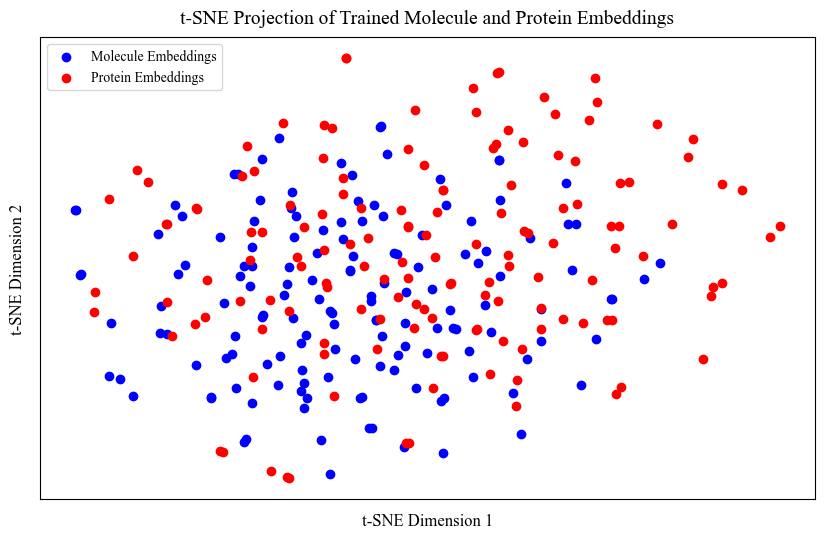

In [ ]:
# Load custom Times New Roman font
font_path = '../times.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Times New Roman'

# Set the device (use GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate embeddings using the trained model
with torch.no_grad():
    prot_emb = prot_emb.to(device)
    mol_emb = mol_emb.to(device)
    trained_prot_emb = model.protein_projector(prot_emb)
    trained_mol_emb = model.molecule_projector(mol_emb)

# Transfer embeddings to CPU for t-SNE processing
trained_prot_emb_cpu = trained_prot_emb.cpu()
trained_mol_emb_cpu = trained_mol_emb.cpu()

# Apply t-SNE for dimensionality reduction
tsne_model = TSNE(n_components=2, random_state=42)
prot_emb_2d = tsne_model.fit_transform(trained_prot_emb_cpu)
mol_emb_2d = tsne_model.fit_transform(trained_mol_emb_cpu)

# Plot the distribution of embeddings after dimensionality reduction
plt.figure(figsize=(10, 6))
plt.scatter(mol_emb_2d[:, 0], mol_emb_2d[:, 1], c='blue', label='Molecule Embeddings')
plt.scatter(prot_emb_2d[:, 0], prot_emb_2d[:, 1], c='red', label='Protein Embeddings')

# Add title and legend
plt.title('t-SNE Projection of Trained Molecule and Protein Embeddings', fontsize=14, pad=10)

# Hide axis ticks
plt.xticks([])
plt.yticks([])

# Label axes
plt.xlabel('t-SNE Dimension 1', fontsize=12, labelpad=10)
plt.ylabel('t-SNE Dimension 2', fontsize=12, labelpad=10)

# Add legend
plt.legend(loc='upper left')

# Save the plot to a file
plt.savefig('../figures/trained_embedding_projection.png', format='png', dpi=600)

# Display the plot
plt.show()